# Energy Efficiency <br>
by <br>
Mike Nelson and  <br>
Rebekah Silva <br>
May 2022

## Problem Statement <br>
According to Energy.gov 35% of a building’s energy consumption comes from heating, ventilation, and air conditioning.    We spend a large amount of time in buildings and in our residential living spaces, it is increasingly important to consider the performance of a system design to provide occupants with comfortable, cost-efficient, and safe living and work environments. 

Our purpose here is to determine if we can we use machine learning to accurately predict heating and cooling loads from basic building parameters with the goal of making more energy efficient buildings. We are using a dataset from UCI which includes known heating loads(HL) and cooling loads(CL). We will be studying the effect of 8 input variables (relative compactness (X1), surface area(X2), wall area(X3), roof area(X4), overall height(X5), orientation(X6), glazing area(X7) and area distribution(X8). We will use a supervised regression model to predict expected heating and cooling loads.

## Data Source <br>
We are using an Excel document from https://archive.ics.uci.edu/ml/datasets/Energy+efficiency#. <br>
This data set contains 768 samples, with 8 independent variables and 2 dependent variables. These independent variables are building parameters. The dependent variables are the heating and cooling loads for those buildings.

## KPIs

Energy load measurements<br>
Energy load below 20 = low<br>
Energy load between 30 and 40 = medium <br>
Energy load 40 and greater =  high<br>




## Data Dictionary <br>

Column  |  Name  |  Data Type | Description
-----|------------|--------|--------
X1  | Relative Compactness | float | Size to height measurement <br>
X2  | Surface Area | float | Sum of areas of walls and roof  <br>
X3  | Wall Area | float | Sum of areas of walls <br>
X4  | Roof Area | float | Area of roof <br>
X5  | Overall Height | float | 1 or 2 story tall <br>
X6  | Orientation | int | North, South, East, West <br>
X7  | Glazing Area | float | Area of windows <br>
X8  | Glazing Area Distribution | int | Distribution of windows  <br>
y1  | Heating Load | float | Energy cost to heat building <br>
y2  | Cooling Load | float | Energy cost to cool building <br>

### Libraries

First, we will import the libraries that will be used. We import them all together to prevent code errors from missing libraries.

In [2]:
# Load libraries
import pandas as pd
import numpy as np 

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, KFold,cross_val_predict,learning_curve
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

Next, we get our data. The data for this project is stored as a csv in our github account. We are also storing the data in a Panda's dataframe. Pandas gives us lots of tools and methods to transform, slice and more to our data.

In [3]:
url = 'https://raw.githubusercontent.com/pythonandmore/EnergyEfficiency/main/ENB2012_data.csv'
data = pd.read_csv(url)
data.head()


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [4]:
dataset=data[['X1','X2','X3','X4','X5','X6','X7','X8','Y1','Y2']]
dataset.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


Let's rename the columns so it is easier to see what we are talking about in our analysis. 

In [5]:
df = dataset[['X1','X2','X3','X4','X5','X6','X7','X8','Y1','Y2']].rename({'X1':'Compactness','X2':'Surface Area','X3':'Wall Area','X4':'Roof Area','X5':'Height','X6':'Orientation','X7':'Glazing Area','X8':'Glazing Area dist','Y1':'Heating load','Y2':'Cooling load'},axis=1,inplace=False)
 
df.head()

,Compactness,Surface Area,Wall Area,Roof Area,Height,Orientation,Glazing Area,Glazing Area dist,Heating load,Cooling load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


# Data cleaning and renaming columns for improved visualization

Before we get to far, we want to make sure our data isn't missing any values. If it is, we may need to eliminate, row, columns or broadcast an average value for missing elements. 

In [6]:
print('Null Values =', dataset.isnull().values.any())

Null Values = False


Info and Describe are two quick ways to look at the underlying data to see what we have. Info gives a the data type which can be very useful as strings and intergers are treated different. Describe gives us some basic statistics like the range, mean and standard deviation.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Compactness        768 non-null    float64
 1   Surface Area       768 non-null    float64
 2   Wall Area          768 non-null    float64
 3   Roof Area          768 non-null    float64
 4   Height             768 non-null    float64
 5   Orientation        768 non-null    int64  
 6   Glazing Area       768 non-null    float64
 7   Glazing Area dist  768 non-null    int64  
 8   Heating load       768 non-null    float64
 9   Cooling load       768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [8]:
df.describe()

,Compactness,Surface Area,Wall Area,Roof Area,Height,Orientation,Glazing Area,Glazing Area dist,Heating load,Cooling load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


## Data Visualization

We can also plot the data to find insights visually. We are using subplot, which allows us to combine different plots into the same code cell. Our plots are histograms with a distribution line. 

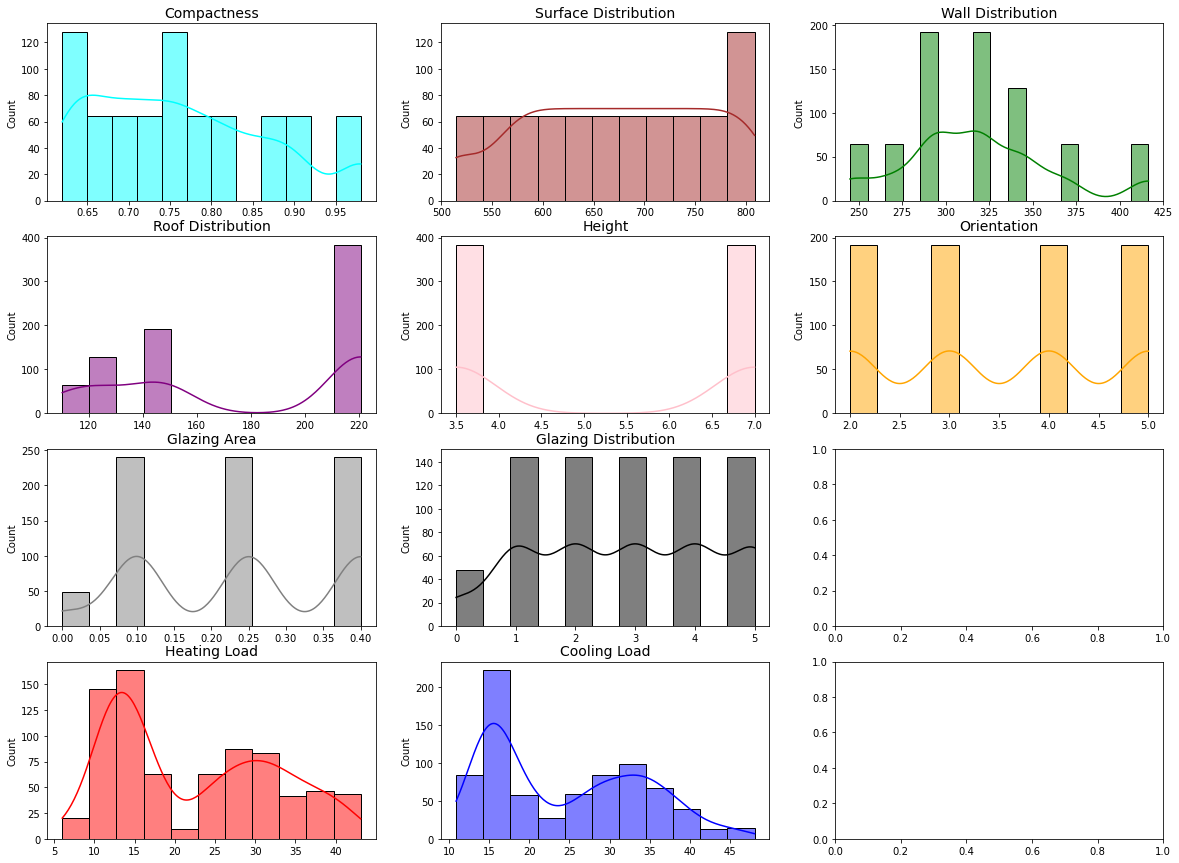

In [9]:
# Visualizations to show area distribution 
fig , ax = plt.subplots(4,3,figsize = (20,15))

Compactness = dataset.X1.values
SurfaceArea = dataset.X2.values
WallArea= dataset.X3.values
RoofArea = dataset.X4.values
Height= dataset.X5.values
Orientation = dataset.X6.values
GlazingArea = dataset.X7.values
GlazingDistb= dataset.X8.values

HeatingLoad = dataset.Y1.values
CoolingLoad = dataset.Y2.values

sns.histplot(Compactness , ax = ax[0,0] , color = 'cyan', kde = True).set_title('Compactness' , fontsize = 14)
sns.histplot(SurfaceArea , ax = ax[0,1] , color = 'brown', kde = True).set_title('Surface Distribution' , fontsize = 14)
sns.histplot(WallArea , ax = ax[0,2] , color = 'green', kde = True).set_title('Wall Distribution' , fontsize = 14)
sns.histplot(RoofArea , ax = ax[1,0] , color = 'purple', kde = True).set_title('Roof Distribution' , fontsize = 14)
sns.histplot(Height , ax = ax[1,1] , color = 'pink', kde = True).set_title('Height' , fontsize = 14)
sns.histplot(Orientation , ax = ax[1,2] , color = 'orange', kde = True).set_title('Orientation' , fontsize = 14)
sns.histplot(GlazingArea , ax = ax[2,0] , color = 'gray', kde = True).set_title('Glazing Area' , fontsize = 14)
sns.histplot(GlazingDistb , ax = ax[2,1] , color = 'black', kde = True).set_title('Glazing Distribution' , fontsize = 14)

sns.histplot(HeatingLoad , ax = ax[3,0] , color = 'red', kde = True).set_title('Heating Load' , fontsize = 14)
sns.histplot(CoolingLoad , ax = ax[3,1] , color = 'blue', kde = True).set_title('Cooling Load' , fontsize = 14)

plt.show()

Another great tool for getting insights is the correlation matrix. Numbers close to 1 and - 1 are highly correlated. Numbers close to zero have little correlation. We have some highly correlated columns (compactness and surface area), so we can remove 1 column without adversely affecting our model. This saves us on computation time when the datasets get really big. 

<AxesSubplot:title={'center':'Correlation Matrix'}>

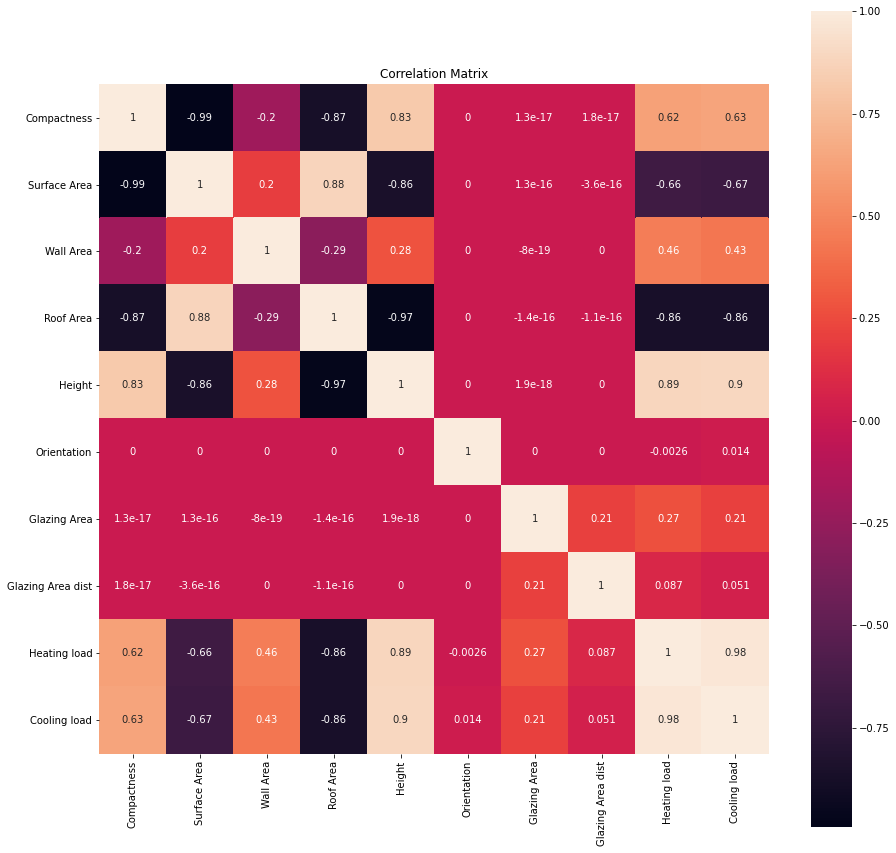

In [10]:
# correlation
correlation = df.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True)

Out last visualization is a pairplot. It combines the histogram and scatter plots. Scatter plots are particular interesting because it is easy to see when there are linear relationships.

/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


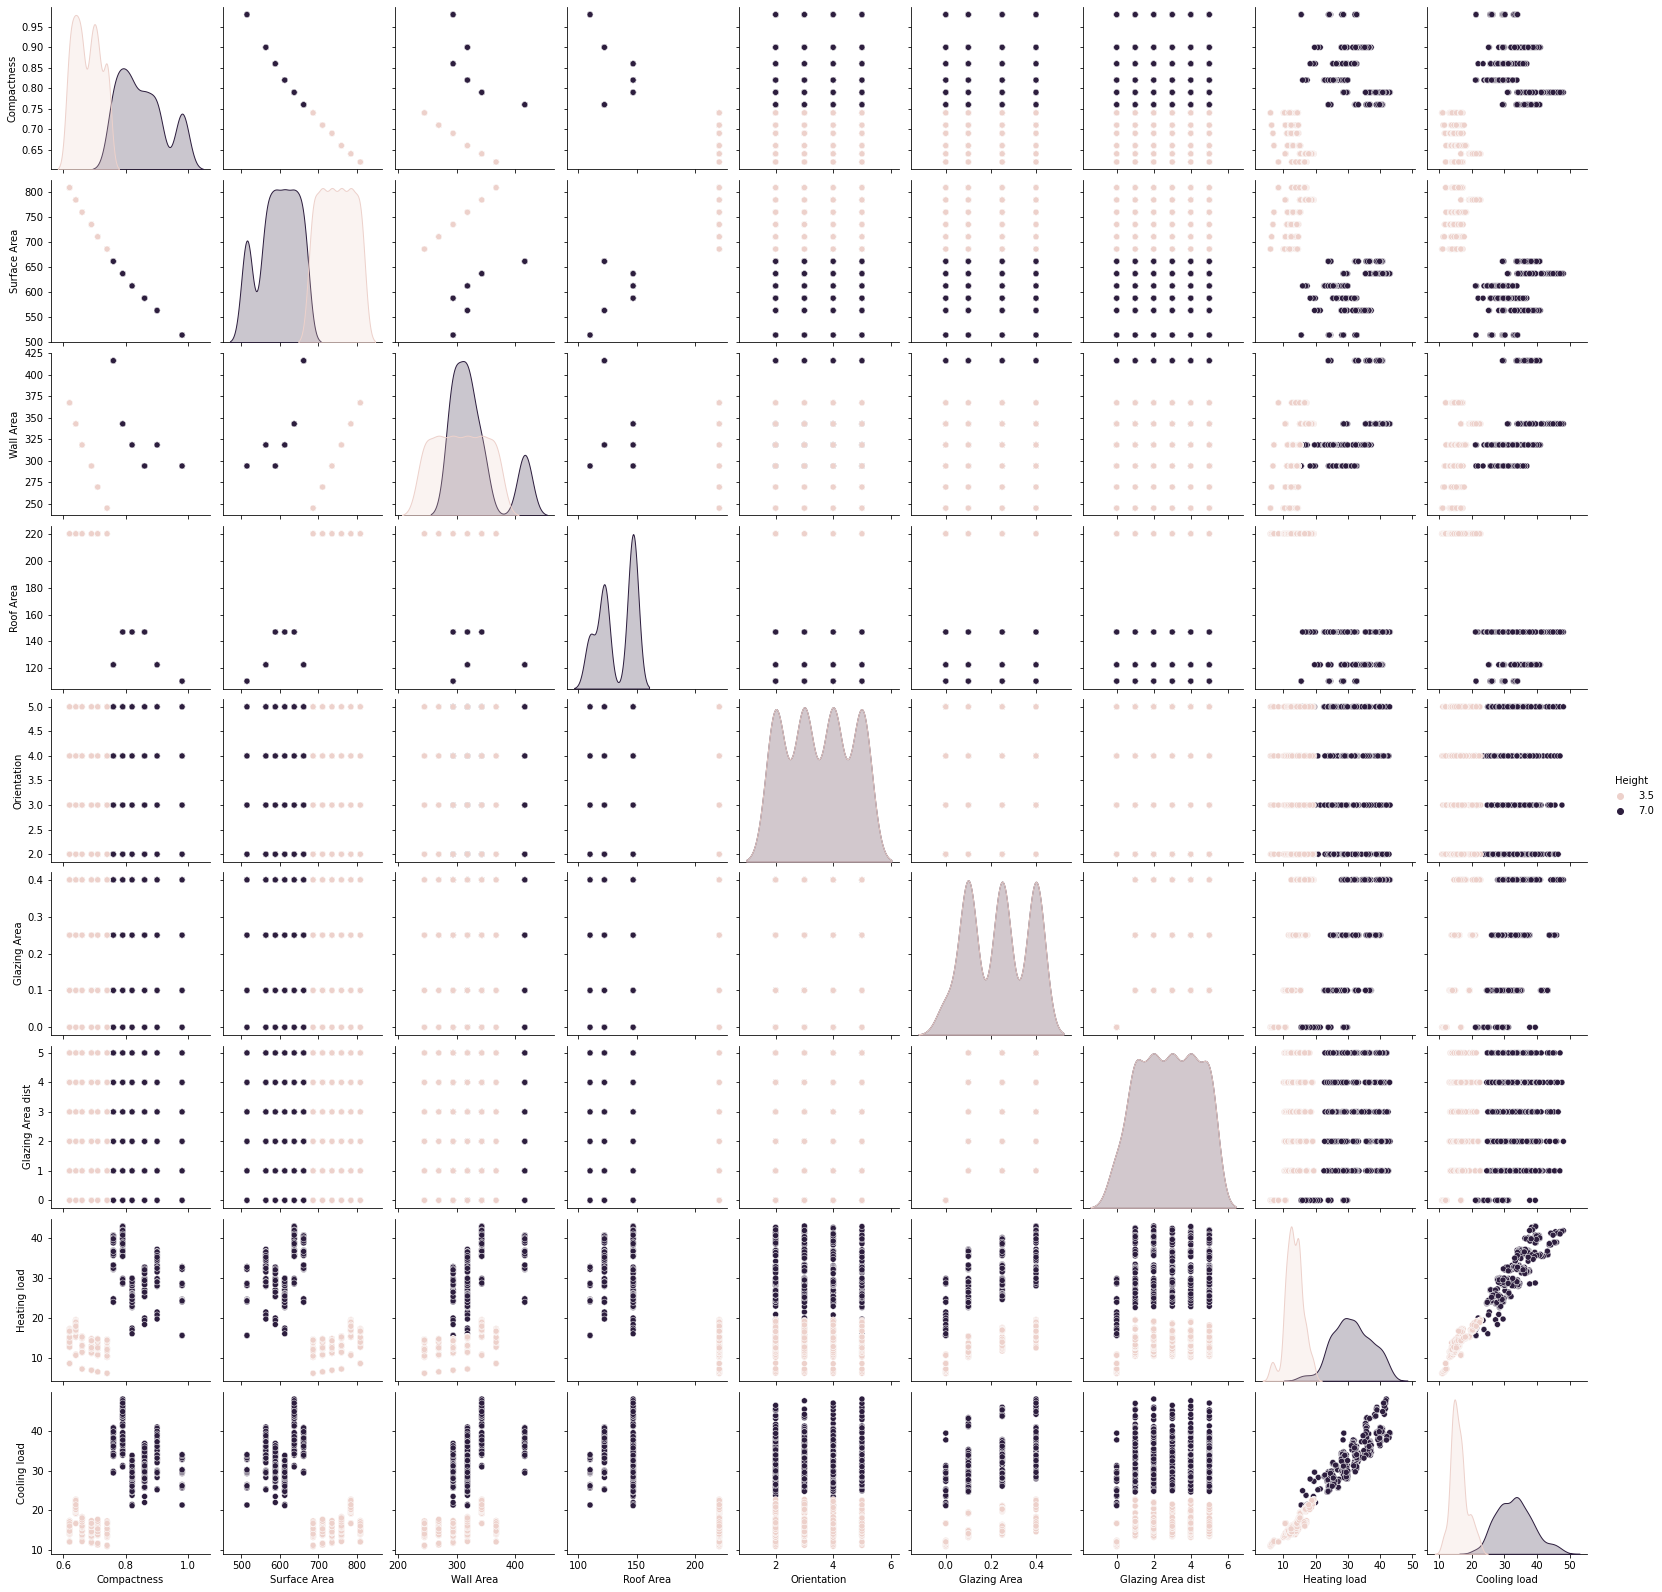

In [11]:
sns.pairplot(df, hue='Height')
plt.show()

With more visualization we can narrow down the impact certain features make on our target variables. 
What we can determine from our visualzation is: 
Building height (3.5) has lower heating load 5-20
Building height (7) has a higher heating load up to 45
Roof area of 220 leads to lower energy loads and coincides with being lower height. 

/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


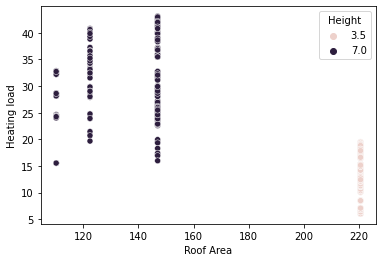

In [12]:
c = sns.scatterplot(df['Roof Area'],df['Heating load'], hue=df['Height'])

/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


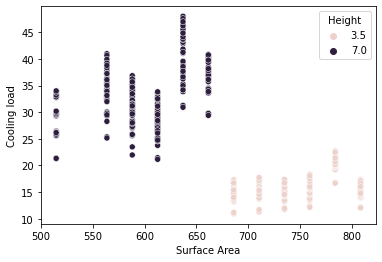

In [13]:
c = sns.scatterplot(df['Surface Area'],df['Cooling load'],hue=df['Height'])

/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


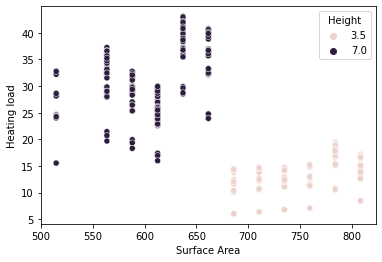

In [14]:
c = sns.scatterplot(df['Surface Area'],df['Heating load'],hue=df['Height'])

Building orientation does not appear to correlate to heating load or cooling loads. 

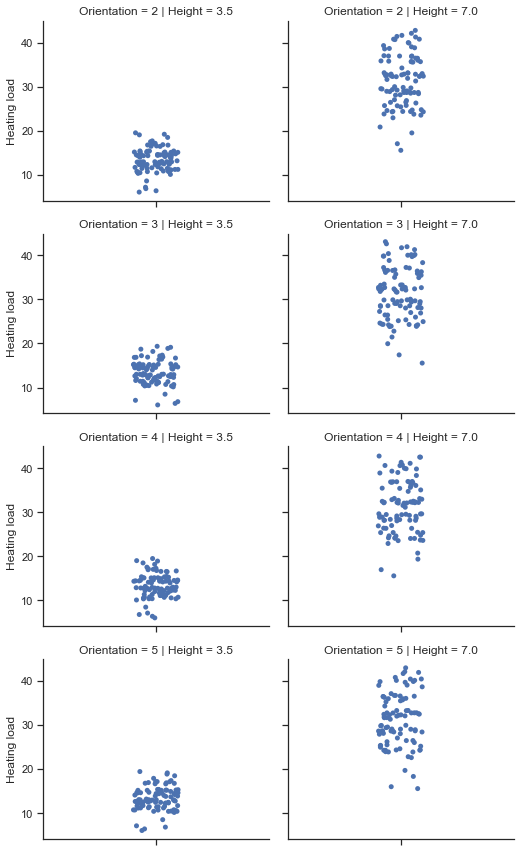

In [15]:
sns.set_theme(style="ticks")
c = sns.catplot(y='Heating load',data=df,col='Height',row='Orientation',hue='Height',
                height=3,  aspect=1.2)

## Linear Regression Model

Now we can build a model. We will start with linear regression because it is a simple model and fast to train/test.

#Target values
y1 = dataset['Y1']
y2 = dataset['Y2']

In [19]:
x=dataset[['X1','X2','X3','X4','X5','X6','X7','X8']]

In [20]:
#Target values
y1 = dataset['Y1']
y2 = dataset['Y2']

In [21]:
#Heating Load - Polynomial Linear Regression - all X variables
x = dataset[['X1','X2','X3','X4','X5','X6','X7','X8']]
x1p = np.array(x)
y1p = np.array(y1)

pf = PolynomialFeatures(degree = 2)
x_poly = pf.fit_transform(x1p)
X_train, X_test, y_train, y_test = train_test_split(x_poly,y1p, test_size = 0.2, random_state = 12)
print('Heating Load - Polynomial Linear Regression - all X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x_poly,y1p, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Heating Load - Polynomial Linear Regression - all X variables
Training data score: 0.995
Testing data score: 0.995
Average cross validation score: 0.956


We now want to see what our results with reduced X variables.  We will drop X2(Surface Area) and X5(Overall Height) for high correlation to X1(Relative Compactness) and X4(Roof Area)respectively. 

In [52]:
#Heating Load - Polynomial Linear Regression - reduced X variables
#dropping X2 and X5 for high correlation to X1 and X4, respectively
x = dataset[['X1','X3','X4','X6','X7','X8']]
x1p = np.array(x)
y1p = np.array(y1)

pf = PolynomialFeatures(degree = 2)
x_poly = pf.fit_transform(x1p)
X_train, X_test, y_train, y_test = train_test_split(x_poly,y1p, test_size = 0.2, random_state = 12)
print('Heating Load - Polynomial Linear Regression - reduced X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x_poly,y1p, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Heating Load - Polynomial Linear Regression - reduced X variables
Training data score: 0.981
Testing data score: 0.98
Average cross validation score: 0.946


In [ ]:
#Heating Load - Linear Regression - reduced X variables

x = dataset[['X1','X3','X4','X6','X7','X8']]

X_train, X_test, y_train, y_test = train_test_split(x,y1, test_size = 0.2, random_state = 12)
print('Heating Load - Linear Regression - reduced X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x,y1, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

In [54]:
#Heating Load - Linear Regression - reduced X variables

x = dataset[['X1','X2','X3','X4','X5','X6','X7','X8']]

X_train, X_test, y_train, y_test = train_test_split(x,y1, test_size = 0.2, random_state = 12)
print('Heating Load - Linear Regression - reduced X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x,y1, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Heating Load - Linear Regression - reduced X variables
Training data score: 0.919
Testing data score: 0.903
Average cross validation score: 0.887


In [55]:
#Cooling Load - Linear Regression - all X variables
x = dataset[['X1','X2','X3','X4','X5','X6','X7','X8']]
X_train, X_test, y_train, y_test = train_test_split(x,y2, test_size = 0.2, random_state = 12)
print('Cooling Load - Linear Regression - all X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x,y2, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Cooling Load - Linear Regression - all X variables
Training data score: 0.894
Testing data score: 0.858
Average cross validation score: 0.874


In [56]:
#Cooling Load - Polynomial Linear Regression - all X variables
x = dataset[['X1','X2','X3','X4','X5','X6','X7','X8']]
x1p = np.array(x)
y2p = np.array(y2)

pf = PolynomialFeatures(degree = 2)
x_poly = pf.fit_transform(x1p)
X_train, X_test, y_train, y_test = train_test_split(x_poly,y2p, test_size = 0.2, random_state = 12)
print('Cooling Load - Polynomial Linear Regression - all X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x_poly,y2p, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Cooling Load - Polynomial Linear Regression - all X variables
Training data score: 0.973
Testing data score: 0.967
Average cross validation score: 0.895


In [57]:
#Cooling Load - Linear Regression - reduced X variables
#dropping X2 and X5 for high correlation to X1 and X4, respectively
x = dataset[['X1','X3','X4','X6','X7','X8']]

X_train, X_test, y_train, y_test = train_test_split(x,y2, test_size = 0.2, random_state = 12)
print('Cooling Load - Linear Regression - reduced X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x,y2, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Cooling Load - Linear Regression - reduced X variables
Training data score: 0.877
Testing data score: 0.832
Average cross validation score: 0.855


In [58]:
#Cooling Load - Polynomial Linear Regression - reduced X variables
#dropping X2 and X5 for high correlation to X1 and X4, respectively
x = dataset[['X1','X3','X4','X6','X7','X8']]
x1p = np.array(x)
y2p = np.array(y2)

pf = PolynomialFeatures(degree = 2)
x_poly = pf.fit_transform(x1p)
X_train, X_test, y_train, y_test = train_test_split(x_poly,y2p, test_size = 0.2, random_state = 12)
print('Cooling Load - Polynomial Linear Regression - reduced X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x_poly,y2p, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Cooling Load - Polynomial Linear Regression - reduced X variables
Training data score: 0.951
Testing data score: 0.941
Average cross validation score: 0.936


# Decision Tree Model 

Below we see that our model is overfitting when all the variables are included. We know this is overfitting because our score is 1. 

In [59]:
from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import AdaBoostRegressor

x = dataset[['X1','X2','X3','X4','X5','X6','X7','X8']]
#x = dataset[['X1','X3','X4','X6','X7','X8']]

X_train, X_test, y_train, y_test = train_test_split(x,y1, test_size = 0.3, random_state = 12)

model = DecisionTreeRegressor()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
model.score(X_test,y_test)

print('Heating Load - Decision Tree Regressor - All X variables')
print('Training data score:', round(model.score(X_train, y_train),3))
print('Testing data score:', round(model.score(X_test, y_test),3))
print('Model score:', round(model.score(X_train, y_train),3))

Heating Load - Decision Tree Regressor - All X variables
Training data score: 1.0
Testing data score: 0.997
Model score: 1.0


When we reduce our features and only exclude the variables with high correlation

In [48]:
from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import AdaBoostRegressor

#x = dataset[['X1','X2','X3','X4','X5','X6','X7','X8']]
x = dataset[['X1','X3','X4','X7','X8']]

X_train, X_test, y_train, y_test = train_test_split(x,y1, test_size = 0.2, random_state = 12)

model = DecisionTreeRegressor()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
model.score(X_test,y_test)

print('Heating Load - Decision Tree Regressor - Reduced X variables')
print('Training data score:', round(model.score(X_train, y_train),3))
print('Testing data score:', round(model.score(X_test, y_test),3))
print('Model score:', round(model.score(X_train, y_train),3))

Heating Load - Decision Tree Regressor - Reduced X variables
Training data score: 0.999
Testing data score: 0.998
Model score: 0.999


In [49]:
from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import AdaBoostRegressor

x = dataset[['X1','X2','X3','X4','X5','X6','X7','X8']]

X_train, X_test, y_train, y_test = train_test_split(x,y2, test_size = 0.2, random_state = 12)

model = DecisionTreeRegressor()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
model.score(X_test,y_test)

print('Cooling Load - Decision Tree Regressor - All X variables')
print('Training data score:', round(model.score(X_train, y_train),3))
print('Testing data score:', round(model.score(X_test, y_test),3))
print('Model score:', round(model.score(X_train, y_train),3))

Cooling Load - Decision Tree Regressor - All X variables
Training data score: 1.0
Testing data score: 0.944
Model score: 1.0


In [51]:
from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import AdaBoostRegressor

x = dataset[['X1','X3','X4','X7','X8']]

X_train, X_test, y_train, y_test = train_test_split(x,y1, test_size = 0.2, random_state = 12)

model = DecisionTreeRegressor()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
model.score(X_test,y_test)

print('Cooling Load - Decision Tree Regressor - reduced X variables')
print('Training data score:', round(model.score(X_train, y_train),3))
print('Testing data score:', round(model.score(X_test, y_test),3))
print('Model score:', round(model.score(X_train, y_train),3))

Cooling Load - Decision Tree Regressor - reduced X variables
Training data score: 0.999
Testing data score: 0.998
Model score: 0.999


<b>We used scikit-learn to set up for plotting the learning curve

In [38]:
def plot_learning_curve(estimator,X,y,train_sizes = [1,16,64,128,512]):
    train_sizes,train_scores,test_scores = learning_curve(estimator,x,y,train_sizes = train_sizes,cv=5)

    mean_train_score = -np.mean(train_scores,axis=1)
    mean_test_score = -np.mean(test_scores,axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, mean_train_score - train_scores_std,
                     mean_train_score + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, mean_test_score - test_scores_std,
                     mean_test_score + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, mean_train_score, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, mean_test_score, 'x-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


   
    plt.figure(figsize = (15,10))
    plt.xlabel('Training size')
    plt.ylabel('Energy load Avg')
    plt.plot(train_sizes,mean_train_score,'o-',color='b',label="Training score")
    plt.plot(train_sizes,mean_test_score,'x-',color='r',label="Cross-validation score")
    plt.legend(loc='best')
    plt.show()

<b> Plot Heating load - y1 

/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: Un

<module 'matplotlib.pyplot' from '/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

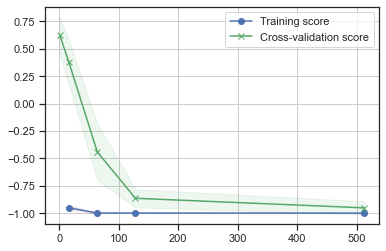

In [39]:
plot_learning_curve(model,x,y1.values.ravel())

<b> Plot the Cooling load - y2

/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: Un

<module 'matplotlib.pyplot' from '/Users/rebekahsilva/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

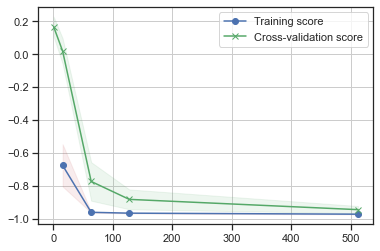

In [40]:
plot_learning_curve(model,x,y2.values.ravel())

<B> Visualization:  actual values versus predictions

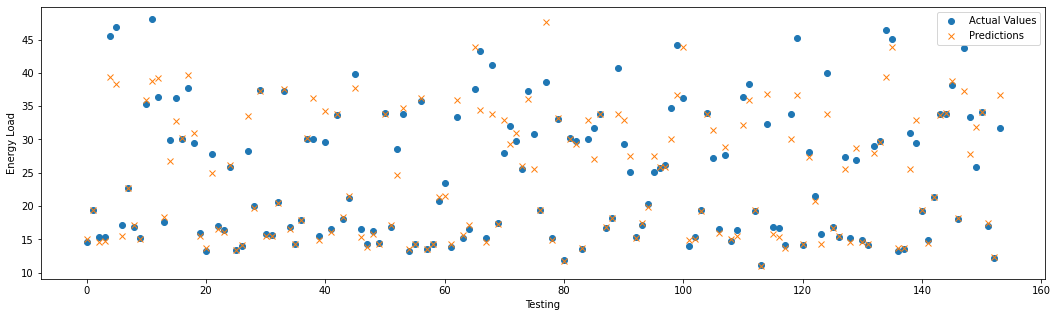

In [117]:
plt.figure(figsize = (18,5))
plt.plot(range(0,len(X_test)),y_test,'o',label = 'Actual Values')
plt.plot(range(0,len(X_test)),predictions,'x',label = 'Predictions')
plt.xlabel('Testing')
plt.ylabel('Energy Load')
plt.legend()
plt.show()